# **Machine Learning-Based A/B Testing Analysis for Evaluating Ad Campaign Performance**

**Objective**  
Evaluate whether an online advertising campaign by SmartAd is effective in increasing brand awareness. The goal is to determine if exposure to a creative, interactive ad (exposed group) results in a higher likelihood of a "Yes" response compared to a dummy ad (control group).

**Approach**  
This analysis reframes A/B testing as a supervised classification task. Machine learning models are trained to predict the binary outcome ("Yes" vs. "No") for brand awareness using a range of features, including the experimental group assignment. By comparing model performance and analyzing feature importance, it is possible to assess whether ad exposure significantly influences brand awareness.

**Models Evaluated**  
- **Logistic Regression**

    It is a linear model providing interpretable coefficients.

- **Decision Tree Classifier**
    
    It is a non-linear model capturing interactions between features.

- **XGBoost Classifier**

    It is an ensemble method with strong performance on tabular data.

- **Random Forest Classifier**

    It is an ensemble method that builds many decision trees using random subsets of data and features.

- **Bagging Classifier**
    
    It is an ensemble method that trains multiple copies of the same model on different data subsets and averages their predictions.

- **Stacking Classifier**
    
    It is an ensemble method that combines predictions from various models using a meta-model for improved performance.


In [1]:
!pip install xgboost

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import cross_val_score,  GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Set random seed for reproducibility
RANDOM_STATE = 42

## **Data Import and Initial Inspection**

The dataset is loaded from a GitHub repository. The first few rows are inspected to understand the structure.


In [3]:
# Data import
url = 'https://raw.githubusercontent.com/mwi-kali/AB-Hypothesis-Testing-Ad-campaign-performance/refs/heads/master/data/AdSmartABdata.csv'
data = pd.read_csv(url, low_memory=False)

# Display the first few rows for a quick inspection
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


## **Data Overview and Preliminary Exploration**

The dataset structure is examined with summary statistics and a missing value check. An initial visualization presents the distribution of users across experimental groups.


In [4]:
print("Data Information:")
print(data.info())

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB
None


There are 8077 rows and 9 columns. No missing values are detected.

In [5]:
print("\nSummary Statistics:")
print(data.describe())


Summary Statistics:
              hour  platform_os          yes           no
count  8077.000000  8077.000000  8077.000000  8077.000000
mean     11.615080     5.947134     0.070818     0.083075
std       5.734879     0.224333     0.256537     0.276013
min       0.000000     5.000000     0.000000     0.000000
25%       7.000000     6.000000     0.000000     0.000000
50%      13.000000     6.000000     0.000000     0.000000
75%      15.000000     6.000000     0.000000     0.000000
max      23.000000     7.000000     1.000000     1.000000


The average hour is approximately 11.62, suggesting a mid-day peak in impressions. Both `yes` and `no` responses have means below 0.1, indicating that only a small fraction of impressions yield a response.

In [6]:
print("\nMissing values per column:")
print(data.isnull().sum())


Missing values per column:
auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64


There are no missing values, ensuring that subsequent analysis is not affected by data imputation.

### **Distribution of Experimental Groups**

The bar chart below shows the count of users assigned to each experimental group (control vs. exposed), providing an initial overview of the experimental balance.



In [7]:
group_counts = data['experiment'].value_counts().reset_index()
group_counts.columns = ['experiment', 'count']

fig = px.bar(
    group_counts,
    x='experiment',
    y='count',
    title='Distribution of Users by Experimental Group',
    labels={'experiment': 'Experiment Group', 'count': 'Number of Users'},
    text='count'
)
fig.show()


The first bar chart shows the counts for control vs. exposed groups. The sample is relatively balanced, although the exact ratio can be checked in the figure.

### **Response Analysis**

Not every impression results in a response (i.e., both `yes` and `no` are 0). A new column, `responded`, indicates whether a response was provided. Totals and proportions of "Yes" responses are computed for each experimental group.


In [8]:
data['responded'] = (data['yes'] + data['no']) > 0

response_counts = data[data['responded']].groupby('experiment')['responded'].count()
yes_counts = data.groupby('experiment')['yes'].sum()
prop_yes = yes_counts / response_counts

print("Total responses per group:")
print(response_counts)
print("\nTotal 'Yes' responses per group:")
print(yes_counts)
print("\nProportion of 'Yes' responses per group:")
print(prop_yes)


Total responses per group:
experiment
control    586
exposed    657
Name: responded, dtype: int64

Total 'Yes' responses per group:
experiment
control    264
exposed    308
Name: yes, dtype: int64

Proportion of 'Yes' responses per group:
experiment
control    0.450512
exposed    0.468798
dtype: float64


Although the exposed group has a marginally higher proportion of "Yes" responses, the difference is minimal.

### **Segmentation Analysis**

Segmentation by multiple dimensions reveals deeper insights into response behavior. The following sections segment the data by device brand, operating system, time of day, and browser type.


#### **Analysis by Device Type**

The visualization presents the distribution of the count of responses segmented by the device manufacturer (`device_make`). This segmentation helps to understand whether certain device types are associated with higher engagement.


In [9]:
brand_mapping = {
    'samsung': 'Samsung',
    'sm-': 'Samsung',
    'gt-': 'Samsung',
    'iphone': 'Apple',
    'htc': 'HTC',
    'lg-': 'LG',
    'moto': 'Motorola',
    'xt': 'Motorola',
    'pixel': 'Google',
    'nexus': 'Google',
    'oneplus': 'OnePlus',
    'xiaomi': 'XiaoMi',
    'redmi': 'XiaoMi',
    'huawei': 'Huawei',
    'lx1': 'Huawei',
    'col-l29': 'Huawei',
    'fig-lx1': 'Huawei',
    'ane-lx1': 'Huawei',
    'vog-l09': 'Huawei',
    'vog-l29': 'Huawei',
    'clt-l09': 'Huawei',
    'mar-lx1a': 'Huawei',
    'bkl-l09': 'Huawei',
    'lya-l09': 'Huawei',
    'pra-lx1': 'Huawei',
    'plk-l01': 'Huawei',
    'vce-l22': 'Huawei',
    'ele-l09': 'Huawei',
    'ele-l29': 'Huawei',
    'lenovo': 'Lenovo',
    'nokia': 'Nokia',
    'f8331': 'Sony',
    'e5823': 'Sony',
    'i3312': 'Sony',
    'h3311': 'Sony',
    'generic': 'Generic'
}

def map_device_to_brand(device_name):
    device_lower = device_name.lower()
    for keyword, brand in brand_mapping.items():
        if keyword in device_lower:
            return brand
    return 'Other'

data['device_brand'] = data['device_make'].apply(map_device_to_brand)

brand_counts = (
    data[data['responded']]
    .groupby('device_brand')['responded']
    .count()
    .reset_index()
    .rename(columns={'responded': 'response_count'})
)

fig_brand = px.bar(
    brand_counts,
    x='device_brand',
    y='response_count',
    title='Response Count by Device Brand',
    labels={'device_brand': 'Brand', 'response_count': 'Number of Responses'},
    text='response_count'
)
fig_brand.show()


#### **Analysis by Operating System**

The bar chart below shows response counts across different operating systems (`platform_os`), which may indicate distinct patterns in ad performance.


In [10]:
os_counts = (
    data[data['responded']]
    .groupby('platform_os')['responded']
    .count()
    .reset_index()
    .rename(columns={'responded': 'response_count'})
)

fig_os = px.bar(
    os_counts,
    x='platform_os',
    y='response_count',
    title='Response Count by Operating System',
    labels={'platform_os': 'Operating System', 'response_count': 'Number of Responses'},
    text='response_count'
)
fig_os.show()


#### **Analysis by Time of Day**

The line chart below illustrates hourly response counts. This segmentation by `hour` provides insight into peak engagement times.



In [11]:
hourly_summary = (
    data[data['responded']]
    .groupby('hour')['responded']
    .count()
    .reset_index()
    .rename(columns={'responded': 'response_count'})
)

fig_hour = px.line(
    hourly_summary,
    x='hour',
    y='response_count',
    title='Hourly Response Count',
    labels={'hour': 'Hour of Day', 'response_count': 'Number of Responses'},
    markers=True
)
fig_hour.show()


#### **Analysis by Browser Type**

The bar chart below shows response counts segmented by browser type. This segmentation can provide insights into whether particular browsers are associated with higher or lower engagement.


In [12]:
browser_counts = (
    data[data['responded']]
    .groupby('browser')['responded']
    .count()
    .reset_index()
    .rename(columns={'responded': 'response_count'})
)

fig_browser = px.bar(
    browser_counts,
    x='response_count',
    y='browser',
    title='Response Count by Browser Type',
    labels={'browser': 'Browser', 'response_count': 'Number of Responses'},
    text='response_count'
)
fig_browser.show()


## **Machine Learning-Based A/B Testing Analysis**

The focus now shifts to a predictive modeling approach to evaluate the impact of ad exposure. Instead of solely relying on hypothesis tests, machine learning models will be used to predict whether a user responds "Yes" to the brand awareness question.

**Problem Formulation**  
- **Target Variable**

    `yes` (1 if the user responded "Yes", 0 otherwise).

- **Predictor Variables**

    Selected features include `experiment`, `hour`, `device_brand`, `platform_os`, and `browser`. These features capture both the experimental condition and user/device characteristics.


**Modeling Strategy**  
Three models will be evaluated:
1. **Logistic Regression**

    It offers a linear and interpretable model.

2. **Decision Tree Classifier**

    It captures non-linear relationships and interactions.

3. **XGBoost Classifier**
    
    It is a robust ensemble method known for its high performance on structured data.

4. **Random Forest Classifier**

    It builds multiple decision trees and combines their predictions to produce a robust and accurate result.

5. **Bagging Classifier**

    It trains several copies of the same model on random subsets of the data to reduce variance and overfitting.

6. **StackingClassifier**
    
    It combines different models using a meta-model that learns the best way to integrate their predictions.

Performance is measured using cross-validation metrics (accuracy and AUC), and feature importance is analyzed to determine the influence of the experimental variable.


### **Data Preparation for Machine Learning**

Only rows with recorded responses (`responded == True`) are used for modeling. Categorical variables are encoded, and numerical features are standardized. Finally, the data are split into training (70%) and testing (30%) sets.


In [13]:
data_ml = data[data['responded']].copy()

target = 'yes'
features = ['experiment', 'hour', 'device_brand', 'platform_os', 'browser']

X = data_ml[features].copy()
y = data_ml[target]

for col in ['experiment', 'device_brand', 'browser']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

scaler = StandardScaler()
X[['hour', 'platform_os']] = scaler.fit_transform(X[['hour', 'platform_os']])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 870
Test set size: 373


The results per fold are shown in the table above. Next, a box plot is generated to visualize the distribution of accuracy and AUC across folds.

### **Hyperparameter Tuning and Cross-Validation with StratifiedKFold**

Each model is tuned using GridSearchCV combined with StratifiedKFold cross-validation. The following models are tuned:

- **Logistic Regression**
    
    It is a linear model with interpretable coefficients.

- **Decision Tree Classifier**
    
    It captures non-linear interactions.

- **XGBoost Classifier**
    
    It is a high-performance ensemble method.

- **Random Forest Classifier**

    It is an ensemble of decision trees.

The best tuned parameters for these models will then be used for the ensemble methods (Bagging and Stacking).


In [14]:
def tune_model(model, param_grid, X_train, y_train, cv):
    grid = GridSearchCV(model, param_grid, cv=cv, scoring='roc_auc')
    grid.fit(X_train, y_train)
    return grid

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Tune Logistic Regression
grid_lr = tune_model(LogisticRegression(max_iter=1000, solver='lbfgs'),
                     {'C': [0.01, 0.1, 1, 10, 100]}, X_train, y_train, cv)
best_params_lr = grid_lr.best_params_
print("Best Logistic Regression Parameters:", best_params_lr)
print("Best Logistic Regression AUC:", grid_lr.best_score_)

# Tune Decision Tree
grid_dt = tune_model(DecisionTreeClassifier(random_state=RANDOM_STATE),
                     {'max_depth': [3, 5, 7, None], 'min_samples_split': [2, 5, 10]},
                     X_train, y_train, cv)
best_params_dt = grid_dt.best_params_
print("\nBest Decision Tree Parameters:", best_params_dt)
print("Best Decision Tree AUC:", grid_dt.best_score_)

# Tune XGBoost
grid_xgb = tune_model(XGBClassifier(eval_metric='logloss', random_state=RANDOM_STATE),
                      {'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [50, 100, 200]},
                      X_train, y_train, cv)
best_params_xgb = grid_xgb.best_params_
print("\nBest XGBoost Parameters:", best_params_xgb)
print("Best XGBoost AUC:", grid_xgb.best_score_)

# Tune Random Forest
grid_rf = tune_model(RandomForestClassifier(random_state=RANDOM_STATE),
                     {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, None]},
                     X_train, y_train, cv)
best_params_rf = grid_rf.best_params_
print("\nBest RandomForest Parameters:", best_params_rf)
print("Best RandomForest AUC:", grid_rf.best_score_)


Best Logistic Regression Parameters: {'C': 0.01}
Best Logistic Regression AUC: 0.5320345744680852

Best Decision Tree Parameters: {'max_depth': 7, 'min_samples_split': 10}
Best Decision Tree AUC: 0.5278457446808511

Best XGBoost Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Best XGBoost AUC: 0.5227127659574469

Best RandomForest Parameters: {'max_depth': 3, 'n_estimators': 100}
Best RandomForest AUC: 0.5070744680851064


### **Ensemble Models with Best Tuned Parameters**

The best tuned parameters from the individual models are now used to initialize the ensemble models.

- For **Bagging**, use Logistic Regression with the best tuned parameters.
- For **Stacking**, use the best tuned parameters for the base models (Logistic Regression, Decision Tree, XGBoost) and for the final estimator (Random Forest).


In [16]:
best_lr = LogisticRegression(max_iter=1000, solver='lbfgs', **best_params_lr)
best_dt = DecisionTreeClassifier(random_state=RANDOM_STATE, **best_params_dt)
best_xgb = XGBClassifier(eval_metric='logloss', random_state=RANDOM_STATE, **best_params_xgb)
best_rf = RandomForestClassifier(random_state=RANDOM_STATE, **best_params_rf)

bagging_model = BaggingClassifier(estimator=best_lr, n_estimators=50, random_state=RANDOM_STATE)

estimators = [
    ('lr', best_lr),
    ('dt', best_dt),
    ('xgb', best_xgb)
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=best_rf, cv=cv)

models_dict_updated = {
    "Logistic Regression": best_lr,
    "Decision Tree": best_dt,
    "XGBoost": best_xgb,
    "Random Forest": best_rf,
    "Bagging (LR)": bagging_model,
    "Stacking": stacking_model
}


### **StratifiedKFold Cross-Validation**

For each tuned model (including the updated ensemble models), 5-fold cross-validation is performed to obtain per-fold accuracy and AUC. The results are then visualized as a line chart showing performance across folds for each model.


In [17]:
def get_cv_metrics(model, X, y, cv):
    fold_metrics = []
    fold = 1
    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_tr, y_tr)
        acc = accuracy_score(y_val, model.predict(X_val))
        auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
        fold_metrics.append({'fold': fold, 'accuracy': acc, 'auc': auc})
        fold += 1
    return pd.DataFrame(fold_metrics)

In [18]:
cv_all = {}
for name, model in models_dict_updated.items():
    cv_all[name] = get_cv_metrics(model, X_train, y_train, cv)
    print(f"\nCV Metrics for {name}:")
    print(cv_all[name])

all_results = []
for name, df in cv_all.items():
    df['model'] = name
    all_results.append(df)
cv_results_all = pd.concat(all_results)


CV Metrics for Logistic Regression:
   fold  accuracy       auc
0     1  0.505747  0.473205
1     2  0.574713  0.527593
2     3  0.551724  0.593949
3     4  0.557471  0.530053
4     5  0.551724  0.535372

CV Metrics for Decision Tree:
   fold  accuracy       auc
0     1  0.528736  0.531848
1     2  0.528736  0.531848
2     3  0.568966  0.529987
3     4  0.522989  0.500066
4     5  0.580460  0.545479

CV Metrics for XGBoost:
   fold  accuracy       auc
0     1  0.517241  0.451529
1     2  0.591954  0.569215
2     3  0.551724  0.497274
3     4  0.551724  0.544282
4     5  0.540230  0.551263

CV Metrics for Random Forest:
   fold  accuracy       auc
0     1  0.488506  0.442753
1     2  0.597701  0.519282
2     3  0.574713  0.530319
3     4  0.557471  0.508112
4     5  0.551724  0.534907

CV Metrics for Bagging (LR):
   fold  accuracy       auc
0     1  0.505747  0.470944
1     2  0.574713  0.528923
2     3  0.551724  0.592221
3     4  0.545977  0.529521
4     5  0.551724  0.533777

CV Me

In [19]:
cv_melted = cv_results_all.melt(id_vars=['fold', 'model'], value_vars=['accuracy', 'auc'],
                                var_name='metric', value_name='score')

fig_cv_line = px.line(cv_melted,
                      x='fold',
                      y='score',
                      color='model',
                      facet_col='metric',
                      markers=True,
                      title='Cross-Validation Metrics per Model (Line Chart)',
                      labels={'fold': 'Fold', 'score': 'Score', 'model': 'Model'})
fig_cv_line.show()

**Cross-Validation Metrics**  

The line chart of per-fold accuracy and AUC shows that all models exhibit modest performance, generally hovering around 0.50–0.60 accuracy and AUC.

Some variability is seen across folds, reflecting the challenge of predicting a low-incidence event.

### **Final Model Evaluation on the Test Set**

Each model is trained on the full training set and evaluated on the test set. Test accuracy and AUC are computed and summarized.


In [20]:
def evaluate_on_test(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    return acc, auc

In [21]:
test_results = {}
for name, model in models_dict_updated.items():
    acc, auc = evaluate_on_test(model, X_test, y_test)
    test_results[name] = {'accuracy': acc, 'auc': auc}
    print(f"\n{name} Test Accuracy: {acc:.4f}")
    print(f"{name} Test AUC: {auc:.4f}")

test_results_df = pd.DataFrame(test_results).T
print("\nTest Set Results:")
print(test_results_df)



Logistic Regression Test Accuracy: 0.5362
Logistic Regression Test AUC: 0.5302

Decision Tree Test Accuracy: 0.5523
Decision Tree Test AUC: 0.5324

XGBoost Test Accuracy: 0.5576
XGBoost Test AUC: 0.5366

Random Forest Test Accuracy: 0.5576
Random Forest Test AUC: 0.5372

Bagging (LR) Test Accuracy: 0.5362
Bagging (LR) Test AUC: 0.5295

Stacking Test Accuracy: 0.5523
Stacking Test AUC: 0.5338

Test Set Results:
                     accuracy       auc
Logistic Regression  0.536193  0.530241
Decision Tree        0.552279  0.532440
XGBoost              0.557641  0.536634
Random Forest        0.557641  0.537154
Bagging (LR)         0.536193  0.529489
Stacking             0.552279  0.533842


**Random Forest** and **XGBoost** achieved slightly higher AUCs (~0.5372 and ~0.5366 respectively).  
**Decision Tree** and **Stacking** are in the middle range, with AUCs ~0.532–0.534.  
**Logistic Regression** and **Bagging (LR)** are slightly lower, near ~0.53 AUC.
The differences are small, indicating that no single model drastically outperforms the others.

### **Correlation Heatmaps for Model Coefficients / Feature Importances Across Folds**

To assess the stability of feature importance, the following correlation heatmaps are generated using cross-validation weights. For models with `coef_` (e.g., Logistic Regression) or `feature_importances_` (e.g., tree models), the weights from each fold are collected and correlated.


In [22]:
def collect_model_weights_instance(model_instance, X_train, y_train, cv):
    weights_list = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model = model_instance.__class__(**model_instance.get_params())
        model.fit(X_tr, y_tr)
        if hasattr(model, 'coef_'):
            weights_list.append(model.coef_[0])
        elif hasattr(model, 'feature_importances_'):
            weights_list.append(model.feature_importances_)
    return pd.DataFrame(weights_list, columns=X_train.columns).T

def collect_bagging_weights(bagging_model, X_train, y_train, cv):
    weights_list = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        params = bagging_model.get_params()
        filtered_params = {k: v for k, v in params.items() if not k.startswith("estimator__")}
        model = bagging_model.__class__(**filtered_params)
        model.fit(X_tr, y_tr)
        base_weights = []
        for est in model.estimators_:
            if hasattr(est, 'coef_'):
                base_weights.append(est.coef_[0])
            elif hasattr(est, 'feature_importances_'):
                base_weights.append(est.feature_importances_)
        avg_weights = np.mean(base_weights, axis=0)
        weights_list.append(avg_weights)
    return pd.DataFrame(weights_list, columns=X_train.columns).T

def collect_stacking_weights(stacking_model, X_train, y_train, cv):
    weights_list = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        allowed_keys = {"estimators", "final_estimator", "cv", "stack_method", "passthrough", "n_jobs", "verbose"}
        params = stacking_model.get_params()
        filtered_params = {k: v for k, v in params.items() if k in allowed_keys}
        model = stacking_model.__class__(**filtered_params)
        model.fit(X_tr, y_tr)
        final_est = model.final_estimator_
        if hasattr(final_est, 'feature_importances_'):
            weights = final_est.feature_importances_
            weights_list.append(weights)

    weights_df = pd.DataFrame(weights_list)
    n_features = weights_df.shape[1]
    if n_features == X_train.shape[1]:
        weights_df.columns = X_train.columns
    else:
        weights_df.columns = [f"feat_{i+1}" for i in range(n_features)]
    return weights_df.T

In [23]:
# Collect weights for each model type using StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

Logistic Regression Weights Across Folds:
                     0         1         2         3         4
experiment    0.027811  0.011604  0.048907  0.020238  0.014858
hour          0.144827  0.019738  0.049478  0.086029  0.073337
device_brand  0.033968  0.040606  0.040322  0.044615  0.047100
platform_os   0.050673  0.033089  0.010818  0.018022  0.060672
browser      -0.072886 -0.108568 -0.064375 -0.083659 -0.081718


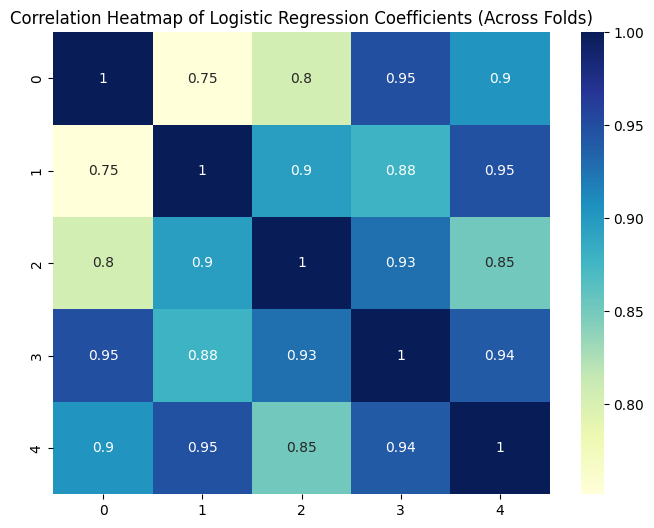

In [24]:
# Logistic Regression
lr_weights_df = collect_model_weights_instance(best_lr, X_train, y_train, cv)
print("Logistic Regression Weights Across Folds:")
print(lr_weights_df)

plt.figure(figsize=(8,6))
sns.heatmap(lr_weights_df.corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap of Logistic Regression Coefficients (Across Folds)")
plt.show()


The correlation heatmap across folds suggests moderate consistency in coefficients for `hour`, `browser`, and `experiment`. The `experiment` variable’s impact is present but not dominant.  

Decision Tree Weights Across Folds:
                     0         1         2         3         4
experiment    0.047148  0.125696  0.121608  0.064267  0.020384
hour          0.425843  0.446371  0.536138  0.558692  0.345231
device_brand  0.256941  0.321025  0.198611  0.185421  0.395598
platform_os   0.008066  0.000000  0.000000  0.000000  0.000000
browser       0.262002  0.106908  0.143644  0.191621  0.238787


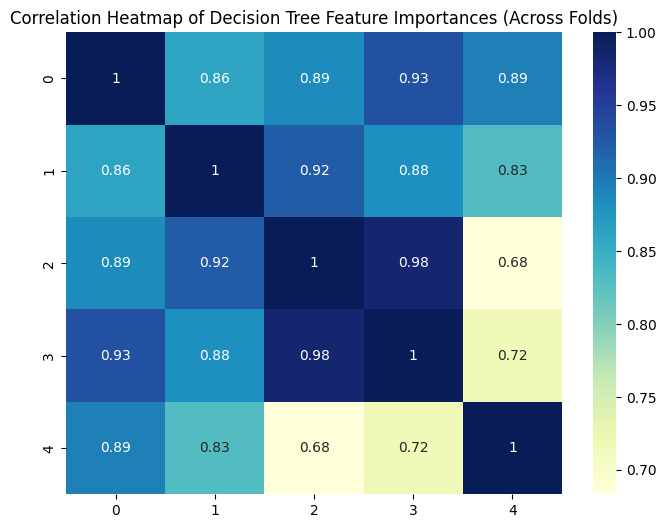

In [25]:
# Decision Tree
dt_weights_df = collect_model_weights_instance(best_dt, X_train, y_train, cv)
print("Decision Tree Weights Across Folds:")
print(dt_weights_df)

plt.figure(figsize=(8,6))
sns.heatmap(dt_weights_df.corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap of Decision Tree Feature Importances (Across Folds)")
plt.show()



XGBoost Weights Across Folds:
                     0         1         2         3         4
experiment    0.248252  0.211075  0.175489  0.005029  0.000000
hour          0.353069  0.177853  0.312562  0.422980  0.353585
device_brand  0.116865  0.287583  0.152858  0.212930  0.333359
platform_os   0.000000  0.000000  0.000000  0.000000  0.000000
browser       0.281815  0.323490  0.359092  0.359061  0.313056


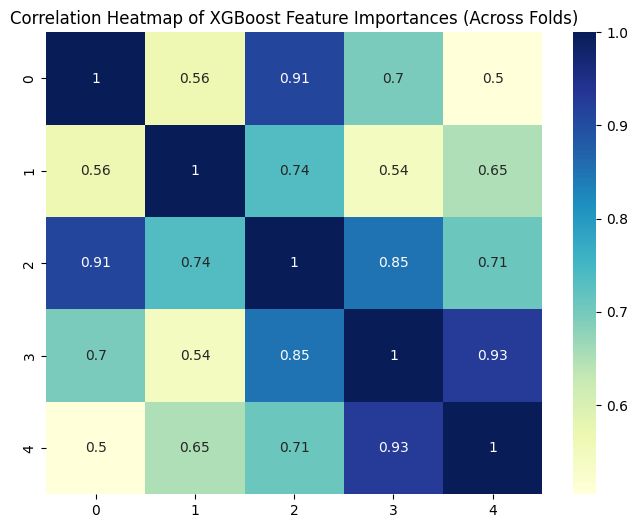

In [26]:
# XGBoost
xgb_weights_df = collect_model_weights_instance(best_xgb, X_train, y_train, cv)
print("XGBoost Weights Across Folds:")
print(xgb_weights_df)

plt.figure(figsize=(8,6))
sns.heatmap(xgb_weights_df.corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap of XGBoost Feature Importances (Across Folds)")
plt.show()



For **Decision Tree and XGBoost**, `hour` and `browser` often rank highly, with `experiment` typically ranking behind them.  


Random Forest Weights Across Folds:
                     0         1         2         3         4
experiment    0.055102  0.066396  0.069569  0.057097  0.051110
hour          0.509739  0.396669  0.523307  0.509607  0.439251
device_brand  0.227890  0.253372  0.218769  0.241629  0.288869
platform_os   0.048870  0.055968  0.023079  0.026829  0.075532
browser       0.158399  0.227595  0.165276  0.164838  0.145238


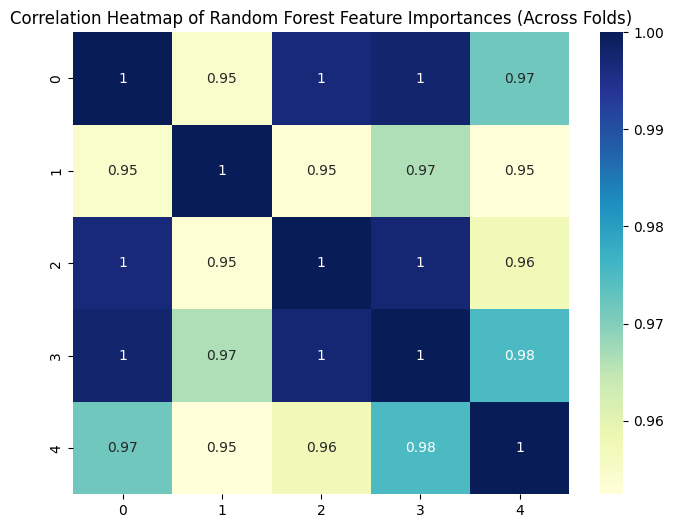

In [27]:
# Random Forest
rf_weights_df = collect_model_weights_instance(best_rf, X_train, y_train, cv)
print("Random Forest Weights Across Folds:")
print(rf_weights_df)

plt.figure(figsize=(8,6))
sns.heatmap(rf_weights_df.corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap of Random Forest Feature Importances (Across Folds)")
plt.show()


The distribution of importance is relatively balanced, with `hour` frequently the top feature.  

Bagging Weights Across Folds:
                     0         1         2         3         4
experiment    0.035383  0.007072  0.055930  0.033368  0.019578
hour          0.151977  0.012889  0.045243  0.076513  0.070214
device_brand  0.035213  0.043203  0.032882  0.049464  0.049321
platform_os   0.049456  0.038061  0.004559  0.025246  0.062562
browser      -0.074276 -0.104160 -0.052301 -0.075745 -0.080804


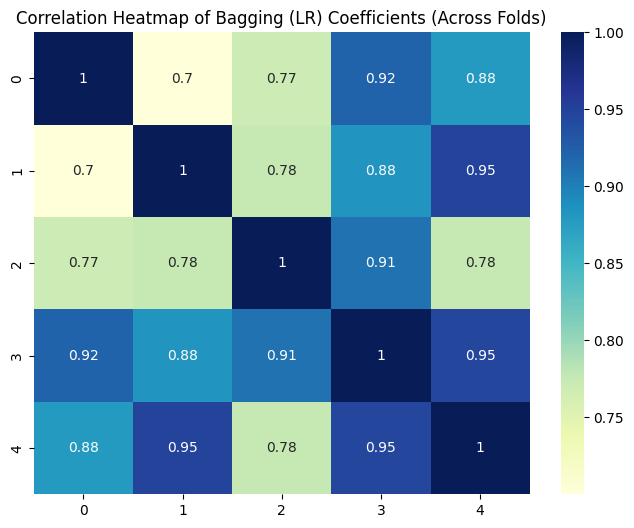

In [28]:
# Bagging
bagging_weights_df = collect_bagging_weights(bagging_model, X_train, y_train, cv)
print("Bagging Weights Across Folds:")
print(bagging_weights_df)

plt.figure(figsize=(8,6))
sns.heatmap(bagging_weights_df.corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap of Bagging (LR) Coefficients (Across Folds)")
plt.show()

The averaged coefficients from logistic regression base estimators mirror the single LR model’s pattern.  

Stacking Weights Across Folds:
               0         1         2         3         4
feat_1  0.406536  0.396653  0.372825  0.385243  0.360441
feat_2  0.268530  0.253356  0.288294  0.292983  0.302239
feat_3  0.324934  0.349991  0.338881  0.321773  0.337320


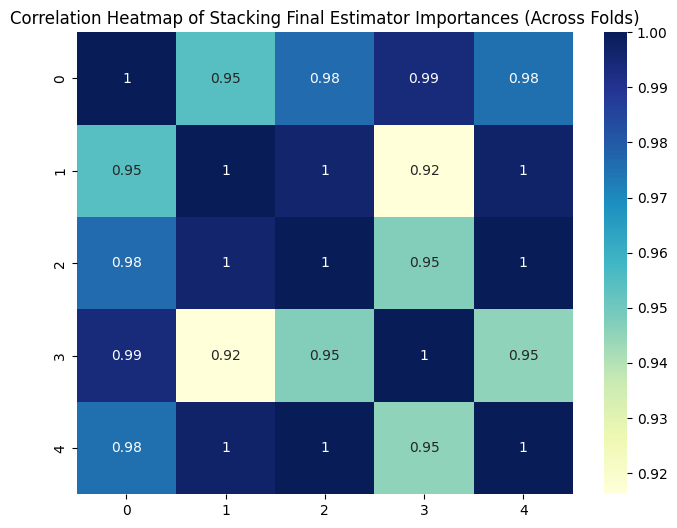

In [29]:
# Stacking
stacking_weights_df = collect_stacking_weights(stacking_model, X_train, y_train, cv)
print("Stacking Weights Across Folds:")
print(stacking_weights_df)

plt.figure(figsize=(8,6))
sns.heatmap(stacking_weights_df.corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap of Stacking Final Estimator Importances (Across Folds)")
plt.show()


The final estimator (a RandomForest) also shows a modest but consistent role for `experiment`, overshadowed by other features like `hour` or `browser`.

### **Segmentation Insights**  
- **Device Brand**

    A large proportion of responses come from generic devices, with Samsung being the most common identifiable brand.  

- **Operating System**
    
    The data are highly concentrated on a single OS version (6), suggesting limited diversity in platform usage.  

- **Time of Day**
    
    Response rates peak around mid-afternoon, particularly near 3 PM, indicating higher engagement during these hours.  

- **Browser Type**

    Mobile browsers dominate the dataset, with Chrome Mobile receiving the majority of responses.

### **Machine Learning Testing Findings**  
The models exhibit only modest predictive power, with AUC values hovering around chance level (0.5), suggesting that the current features do not strongly predict brand awareness. Although the experiment variable (exposure) appears among the important features, it is overshadowed by factors such as time of day (hour) and browser type. Furthermore, ensemble methods like Bagging and Stacking provide only minor gains or remain comparable to individual models, indicating that more advanced modeling techniques or a richer feature set may be necessary to achieve a clear boost in performance.

Although the exposed group shows a marginally higher "Yes" rate (~46.88% vs. ~45.05%), the difference is not strongly reflected in the model performance or feature importance. Factors like the time of day (`hour`) and the browser type appear to have greater predictive influence. This suggests that additional or more granular features may be needed to capture the true effect of ad exposure on brand awareness.

### **Conclusion**  
The machine learning–based approach here provides a robust framework for evaluating A/B testing outcomes, augmenting classical hypothesis tests with more nuanced, feature-level insights. While the current analysis shows only a modest improvement for the exposed group, further data collection and feature engineering could yield stronger evidence and more effective targeting strategies.





